# 📈 Sales Forecasting
This project forecasts daily retail sales by combining historical sales data with external factors such as oil prices, holidays, and store metadata. Using Facebook’s Prophet, it models trends, seasonality, and special events to predict future sales across stores and product families.

## 🎯 Business Problem & Forecasting Impact

Retailers face challenges in optimizing inventory, staffing, and promotions to meet customer demand while minimizing overstock and stockouts. Accurate forecasting enables:

- Optimized inventory management  
- Improved supply chain planning  
- Better alignment of staffing and promotional activities  
- Data-driven strategic decision-making  
- Cost reduction and profit maximization  
- Enhanced product availability and customer satisfaction  

## 📊 Dataset Overview

This dataset comes from the [Kaggle Store Sales Time Series Forecasting competition](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data) and contains daily sales records from multiple retail stores across Ecuador. It combines transactional data with contextual features, providing a rich environment for building realistic forecasting models.

| Dataset               | Description                                          | Key Columns                            |
|-----------------------|------------------------------------------------------|--------------------------------------|
| `train.csv`           | Daily sales per store and product family             | `date`, `store_nbr`, `family`, `sales` |
| `stores.csv`          | Store metadata including location and type           | `store_nbr`, `city`, `state`, `type`, `cluster` |
| `oil.csv`             | Ecuadorian daily oil prices as an economic indicator | `date`, `dcoilwtico` (oil price)     |
| `holidays_events.csv` | Official holidays and special events                  | `date`, `type`, `locale`, `locale_name` |
| `transactions.csv`    | Daily transaction counts per store                     | `date`, `store_nbr`, `transactions`  |

This multi-source dataset reflects real-world retail complexities, enabling sophisticated models that incorporate seasonality, economic signals, and holiday effects.

## 🛠️ Methodology

- Data cleaning and integration of multiple sources  
- Exploratory data analysis to identify trends and holiday impacts  
- Building and tuning Prophet models to capture complex seasonality  
- Model evaluation using MAE and RMSE metrics  
- Visualization of forecasts against actual sales for interpretability  

## 💡 Skills Demonstrated

- Integration and preprocessing of diverse datasets  
- Time series forecasting using Prophet  
- Handling seasonality, trends, and holiday regressors  
- Translating business requirements into actionable insights  
- Effective communication through clear visuals and documentation  

This project showcases an end-to-end data science workflow applicable to retail analytics, supply chain optimization, and demand forecasting roles.

# 🧼 1. Importing and Cleaning Data

The first step involves loading multiple data sources and preparing them for analysis by addressing missing values and ensuring data consistency.

### 📂 Data Loading

- Imported five datasets from Kaggle: `train`, `stores`, `oil`, `transactions`, and `holidays_events`
- Parsed date columns and ensured proper data types for time series analysis

### 🧽 Handling Missing Values

- **Oil Prices:** Forward-filled missing values in `dcoilwtico` to preserve temporal continuity without distorting economic trends
- **Transactions & Holidays:** Filled missing values with zeros to ensure completeness and prevent runtime issues during merging or modeling

### 🔗 Data Integration

- Merged all datasets into a unified DataFrame using appropriate keys (e.g. `date`, `store_nbr`)
- Verified shape before and after joins to prevent unintended row multiplication
- Ensured each join preserved the granularity of the original sales records (one row per store, product family, and day)

### ✅ Why This Matters

Reliable forecasting starts with reliable data. Cleaning and merging these diverse sources ensures that the model captures meaningful signals without being skewed by inconsistencies, missing values, or join errors. This foundational step enables trustworthy forecasting and actionable insights.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from plotly.subplots import make_subplots

### Data Loading

In [2]:
# Load main sales data
train = pd.read_csv('train.csv', parse_dates=['date'])
print(f"Train shape: {train.shape}")

# Check for missing values
missing = train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

# Display nicely
if not missing.empty:
    print("Missing values by column:\n")
    display(missing.to_frame(name='Missing Values'))
else:
    print("✅ No missing values found in the dataset.")
    
train.head()

Train shape: (3000888, 6)
✅ No missing values found in the dataset.


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [3]:
# Load store metadata
stores = pd.read_csv('stores.csv')
print(f"Stores shape: {stores.shape}")

# Check for missing values
missing = stores.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

# Display nicely
if not missing.empty:
    print("Missing values by column:\n")
    display(missing.to_frame(name='Missing Values'))
else:
    print("✅ No missing values found in the dataset.")

stores.head()

Stores shape: (54, 5)
✅ No missing values found in the dataset.


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [4]:
# Load oil prices data
oil = pd.read_csv('oil.csv', parse_dates=['date'])
print(f"Oil shape: {oil.shape}")

# Check for missing values
missing = oil.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

# Display nicely
if not missing.empty:
    print("Missing values by column:\n")
    display(missing.to_frame(name='Missing Values'))
else:
    print("✅ No missing values found in the dataset.")

oil.head()

Oil shape: (1218, 2)
Missing values by column:



,Missing Values
dcoilwtico,43


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [5]:
# Load holidays and events
holidays = pd.read_csv('holidays_events.csv', parse_dates=['date'])
print(f"Holidays shape: {holidays.shape}")

# Check for missing values
missing = holidays.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

# Display nicely
if not missing.empty:
    print("Missing values by column:\n")
    display(missing.to_frame(name='Missing Values'))
else:
    print("✅ No missing values found in the dataset.")

holidays.head()

Holidays shape: (350, 6)
✅ No missing values found in the dataset.


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [6]:
# Load transactions data
transactions = pd.read_csv('transactions.csv', parse_dates=['date'])
print(f"Transactions shape: {transactions.shape}")

# Check for missing values
missing = transactions.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

# Display nicely
if not missing.empty:
    print("Missing values by column:\n")
    display(missing.to_frame(name='Missing Values'))
else:
    print("✅ No missing values found in the dataset.")

transactions.head()

Transactions shape: (83488, 3)
✅ No missing values found in the dataset.


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


### Handling Missing Values in Oil Prices

The `dcoilwtico` column (Ecuadorian oil price) contains missing values, primarily on weekends and holidays when the market is closed and prices are not updated. To address this, we apply **forward-filling** to propagate the last known price to subsequent missing dates.

This approach is appropriate because oil prices generally remain unchanged during non-trading days, making forward-fill a reasonable method to maintain continuity in the time series without introducing bias.

In [7]:
# First, forward-fill
oil['dcoilwtico'] = oil['dcoilwtico'].fillna(method='ffill')

# Then, backward-fill to cover missing values at the start
oil['dcoilwtico'] = oil['dcoilwtico'].fillna(method='bfill')

# Verify no missing values remain
missing_after = oil['dcoilwtico'].isnull().sum()
print(f"Missing oil prices after forward- and backward-fill: {missing_after}")

Missing oil prices after forward- and backward-fill: 0


### Preprocessing Holidays Data for Joining

The original holidays dataset contains multiple entries per date due to variations in holiday types (e.g., national, regional) and locales. Joining this dataset directly to the main sales data on the `date` column causes a one-to-many relationship, leading to row multiplication and distortion of the original dataset size.

To prevent this, the holidays data is preprocessed by aggregating it into a single binary flag per date. This flag (`is_holiday`) indicates whether any holiday occurs on that specific date, regardless of type or locale. Missing values are filled with 0, representing non-holiday dates.

This approach preserves essential temporal holiday information for modeling purposes while maintaining the integrity of the original row count.

In [8]:
print(f"Initial train shape: {train.shape}")

df = train.merge(stores, on='store_nbr', how='left')
print(f"After joining stores: {df.shape}")

df = df.merge(oil, on='date', how='left')
print(f"After joining oil prices: {df.shape}")

df = df.merge(transactions, on=['date', 'store_nbr'], how='left')
print(f"After joining transactions: {df.shape}")

# Create holiday flag
holiday_flag = holidays.groupby('date').size().reset_index(name='holiday_count')
holiday_flag['is_holiday'] = 1

df = df.merge(holiday_flag[['date', 'is_holiday']], on='date', how='left')
df['is_holiday'] = df['is_holiday'].fillna(0).astype(int)
print(f"After joining holiday flags: {df.shape}")

df.head(5)

Initial train shape: (3000888, 6)
After joining stores: (3000888, 10)
After joining oil prices: (3000888, 11)
After joining transactions: (3000888, 12)
After joining holiday flags: (3000888, 13)


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions,is_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,NaN,1
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,NaN,1
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,NaN,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14,NaN,1
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14,NaN,1


In [9]:
# Check for missing values
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

# Display nicely
if not missing.empty:
    print("Missing values by column:\n")
    display(missing.to_frame(name='Missing Values'))
else:
    print("✅ No missing values found in the dataset.")

Missing values by column:



,Missing Values
dcoilwtico,857142
transactions,245784


### Handling Missing Values after Joining

Proper handling of missing values is essential to ensure the quality and accuracy of the forecasting model. Here is the approach taken for the key columns with missing data:

#### 1. `transactions`

- Missing values in the `transactions` column likely indicate that there were no transactions recorded for a given store on a specific date.
- To accurately represent this, missing transaction values are filled with **0**, reflecting zero activity rather than treating it as missing data.
- This prevents loss of rows and maintains data integrity for the model.

#### 2. `dcoilwtico` (Oil Price)

- The `dcoilwtico` column may have missing values because the oil price data does not cover all dates present in the sales dataset.
- Since oil prices tend to change gradually and remain stable on non-trading days, **forward-filling** the last known price is an effective way to fill these gaps.
- Any remaining missing values after forward-fill are then filled with the median oil price as a fallback to avoid null values.

This approach preserves the continuity and completeness of the dataset, enabling more reliable and robust time series forecasting.

In [10]:
# Handling missing values after joining datasets

# Fill missing transactions with 0 (no transactions recorded)
df['transactions'] = df['transactions'].fillna(0).astype(int)

# Forward-fill oil price to propagate last known value for missing dates
df['dcoilwtico'] = df['dcoilwtico'].fillna(method='ffill').astype(int)

# Fill any remaining missing oil prices with median as fallback
df['dcoilwtico'] = df['dcoilwtico'].fillna(df['dcoilwtico'].median()).astype(int)

# Check for missing values
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

# Display nicely
if not missing.empty:
    print("Missing values by column:\n")
    display(missing.to_frame(name='Missing Values'))
else:
    print("✅ No missing values found in the dataset.")

✅ No missing values found in the dataset.


# 🔍 2. Exploratory Data Analysis (EDA)

### 🧠 Objective

The goal of this EDA is to uncover key temporal patterns in sales data—such as trends, seasonality, and holiday effects—that directly inform the structure and design of the forecasting model.

### 📈 Trend Analysis

- Aggregated daily sales across the full time range to identify overall trends  
- Revealed whether sales are generally increasing, decreasing, or stable  
- Helps determine the need for trend components in the forecasting model

### 📅 Weekly Seasonality

- Analyzed average sales by day of the week  
- Highlighted clear behavioral patterns: higher foot traffic on weekends, lower midweek  
- Informs the model to account for cyclical weekly demand

### 🎉 Holiday Effects

- Compared average sales on holidays vs. non-holidays  
- Found significant deviations—either surges or drops—around certain holidays  
- Justifies using holiday regressors in the model

### 🔄 Seasonality Decomposition

- Applied seasonal decomposition to isolate trend, seasonal, and residual components  
- Identified strong yearly cycles and periodic fluctuations in sales volume  
- Confirms the presence of complex seasonality beyond weekly patterns

### ✅ Why This Matters

Recognizing these patterns ensures that the forecasting model mirrors real-world sales behavior. By accounting for recurring cycles, holidays, and overall trends, the model becomes more robust, accurate, and valuable for inventory planning, workforce allocation, and strategic decision-making.

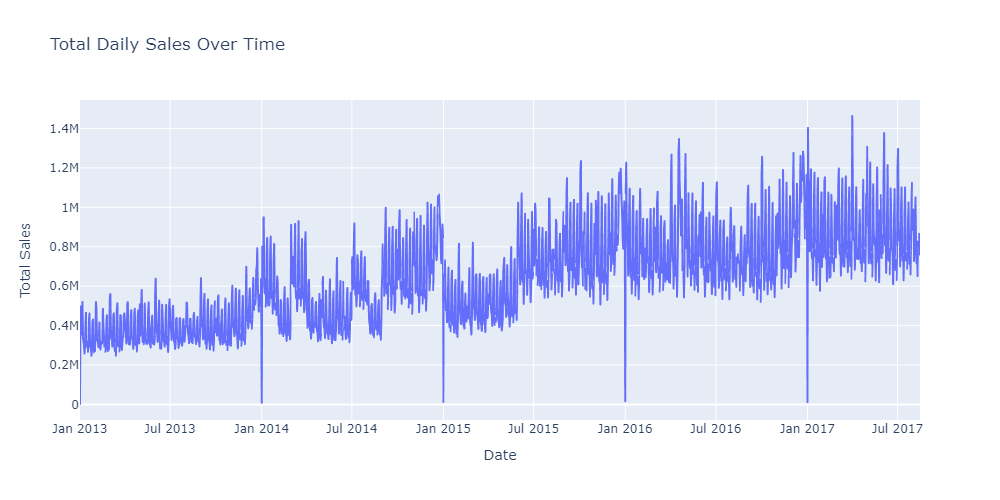

In [11]:
# Aggregate total daily sales across all stores and product families
daily_sales = df.groupby('date')['sales'].sum().reset_index()

# Create a line plot of total sales over time
fig = px.line(
    daily_sales, 
    x='date', 
    y='sales', 
    title='Total Daily Sales Over Time',
    labels={'sales': 'Total Sales', 'date': 'Date'}
)

# Set width to 1000 for readability
fig.update_layout(width=1000, height=500)

# Show as PNG inline in Jupyter
fig.show("png")

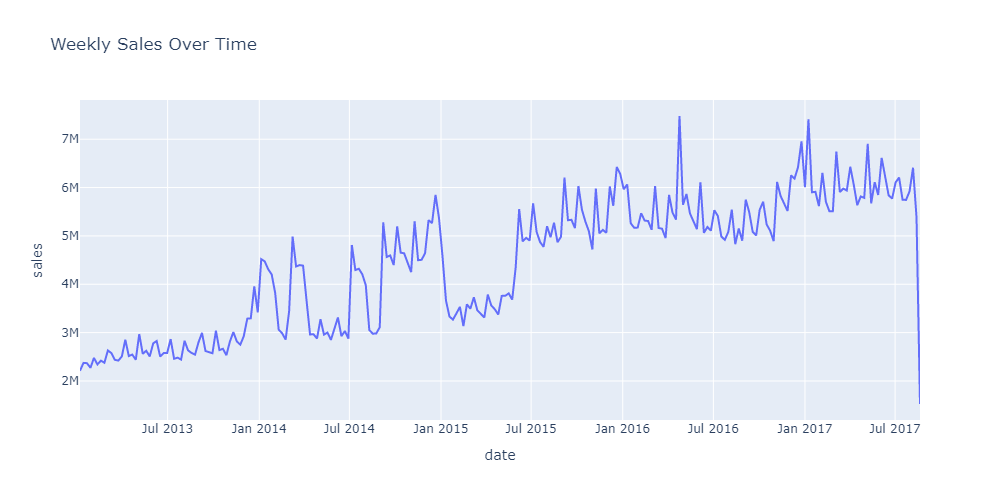

In [12]:
# Weekly sales sum to smooth daily noise
weekly_sales = df.groupby(pd.Grouper(key='date', freq='W'))['sales'].sum().reset_index()

fig = px.line(weekly_sales, x='date', y='sales', title='Weekly Sales Over Time')

# Set width to 1000 for readability
fig.update_layout(width=1000, height=500)

# Show as PNG inline in Jupyter
fig.show("png")

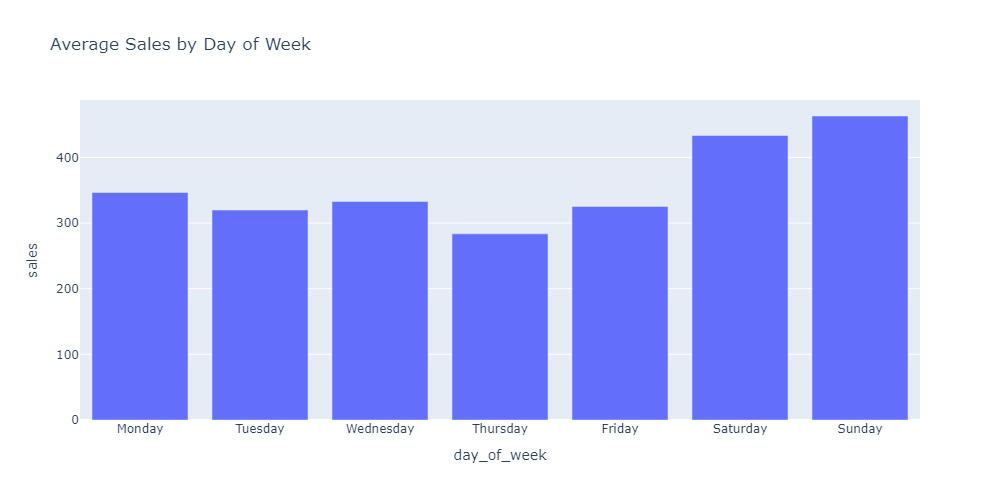

In [13]:
df['day_of_week'] = df['date'].dt.day_name()

avg_sales_dow = df.groupby('day_of_week')['sales'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]).reset_index()

fig = px.bar(avg_sales_dow, x='day_of_week', y='sales', title='Average Sales by Day of Week')

# Set width to 1000 for readability
fig.update_layout(width=1000, height=500)

# Show as PNG inline in Jupyter
fig.show("png")

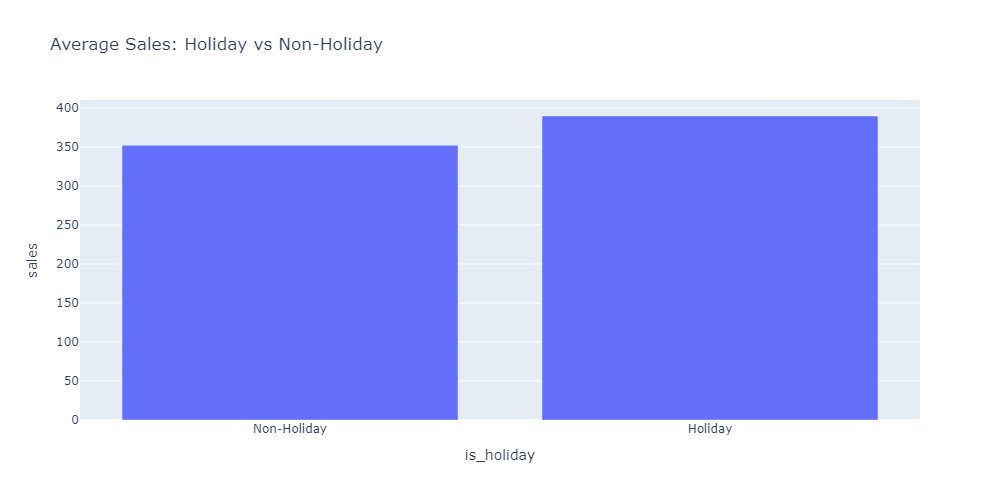

In [14]:
holiday_sales = df.groupby('is_holiday')['sales'].mean().reset_index()
holiday_sales['is_holiday'] = holiday_sales['is_holiday'].map({0: 'Non-Holiday', 1: 'Holiday'})

fig = px.bar(holiday_sales, x='is_holiday', y='sales', title='Average Sales: Holiday vs Non-Holiday')

# Set width to 1000 for readability
fig.update_layout(width=1000, height=500)

# Show as PNG inline in Jupyter
fig.show("png")

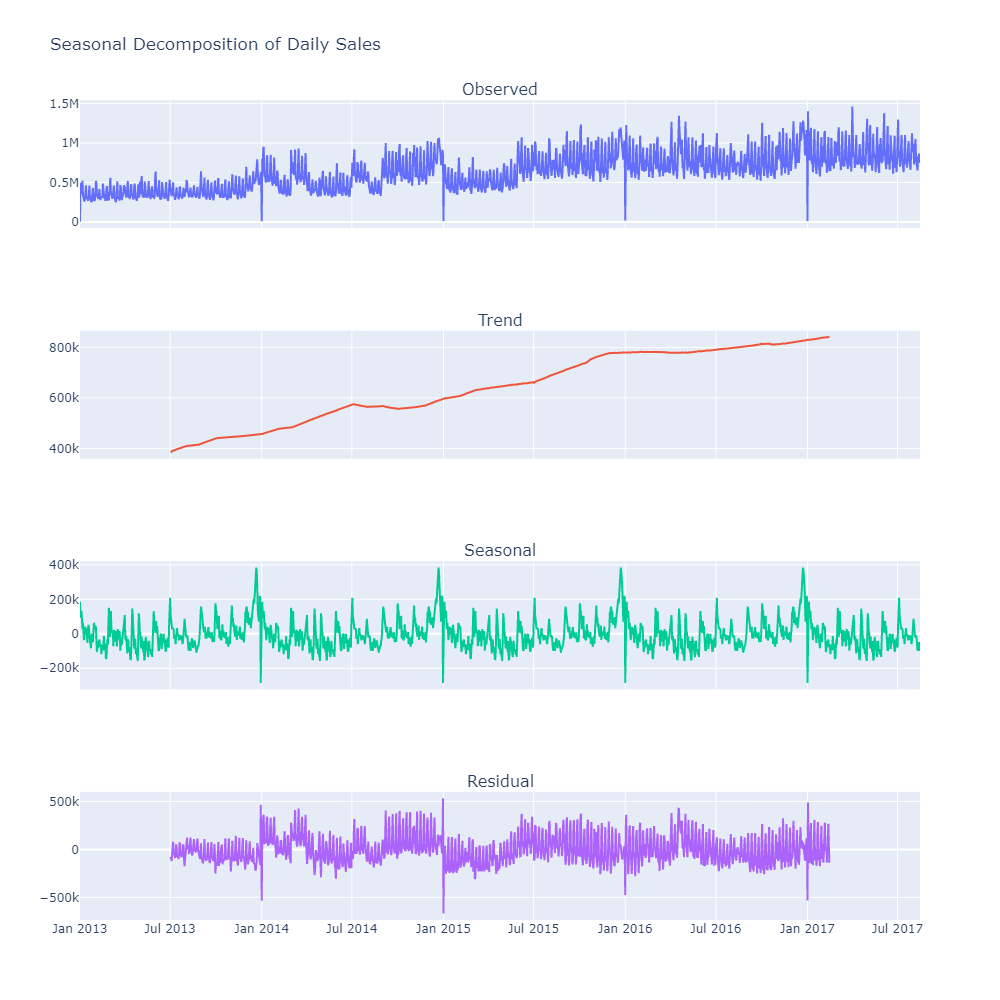

In [15]:
# Aggregate daily sales
daily_sales = df.groupby('date')['sales'].sum()

# Perform seasonal decomposition
result = seasonal_decompose(daily_sales, model='additive', period=365)

# Prepare a Plotly figure with subplots
from plotly.subplots import make_subplots

fig = make_subplots(rows=4, cols=1, shared_xaxes=True,
                    subplot_titles=['Observed', 'Trend', 'Seasonal', 'Residual'])

# Observed
fig.add_trace(go.Scatter(x=daily_sales.index, y=result.observed, name='Observed'), row=1, col=1)
# Trend
fig.add_trace(go.Scatter(x=daily_sales.index, y=result.trend, name='Trend'), row=2, col=1)
# Seasonal
fig.add_trace(go.Scatter(x=daily_sales.index, y=result.seasonal, name='Seasonal'), row=3, col=1)
# Residual
fig.add_trace(go.Scatter(x=daily_sales.index, y=result.resid, name='Residual'), row=4, col=1)

fig.update_layout(width=1000, height=1000, title_text="Seasonal Decomposition of Daily Sales", showlegend=False)

# Show as PNG inline in Jupyter
fig.show("png")

# 📊 3. Forecasting with Prophet

### 🤖 What is Prophet?

[Prophet](https://facebook.github.io/prophet/) is an open-source time series forecasting tool developed by Meta (Facebook). It's designed for simplicity, interpretability, and performance—especially in business settings where strong seasonality and trend shifts are common.

**Key Advantages:**

- Automatically models **daily, weekly, and yearly seasonality**
- Supports **holidays and special events** as regressors
- Tolerates **missing data** and abrupt trend changes
- Requires **minimal tuning**, making it accessible for analysts and data scientists

### 🧠 Forecasting Pipeline Design

To make forecasting repeatable and modular, a custom function was built around Prophet. This function automates the entire forecasting workflow for any store and/or product family:

### 🔧 Pipeline Breakdown

- **🎯 Data Filtering**  
  Focused on specific `store_nbr` and `family` combinations to enable targeted forecasts

- **📆 Aggregation**  
  Grouped by date to sum `sales` and aggregate features like `onpromotion`, `transactions`, `dcoilwtico`, and `is_holiday`

- **📤 Prophet Input Formatting**  
  Converted dataset into Prophet's required structure with `ds` (timestamp) and `y` (target variable)

- **🔀 Train-Test Split**  
  Used a `cutoff_date` to split historical data for model training and post-cutoff evaluation

- **⚙️ Model Configuration**  
  Initialized Prophet and added optional regressors to improve performance

- **🧠 Model Training**  
  Trained the model on historical data with or without regressors

- **📅 Future Data Preparation**  
  Created a future date range, merged with known regressors, and forward-filled missing values

- **📈 Forecast Generation**  
  Generated daily forecasts for the defined horizon (`periods`)

- **🧪 Evaluation**  
  Measured accuracy using **Mean Absolute Error (MAE)** and **Root Mean Squared Error (RMSE)** on the forecasted period

- **📊 Visualization**  
  Built an interactive Plotly chart comparing **actual vs. forecasted** daily sales

### ✅ Why This Matters

This pipeline transforms raw retail data into production-ready forecasts. It’s flexible, interpretable, and reusable across product lines and store locations—making it ideal for:

- 📦 Inventory planning  
- 👥 Workforce allocation  
- 📅 Promotion scheduling  
- 📊 Strategic decision-making  

In [16]:
def forecast_sales_with_prophet(
    df,
    store_nbr=None,
    family=None,
    cutoff_date='2017-06-01',
    periods=90,
    include_regressors=True
):
    # Step 1: Filter by store and/or family
    filtered_df = df.copy()
    if store_nbr is not None:
        filtered_df = filtered_df[filtered_df['store_nbr'] == store_nbr]
    if family is not None:
        filtered_df = filtered_df[filtered_df['family'] == family]
    
    # Step 2: Aggregate daily sales and features
    agg_df = filtered_df.groupby('date').agg({
        'sales': 'sum',
        'onpromotion': 'sum',
        'transactions': 'sum',
        'dcoilwtico': 'mean',
        'is_holiday': 'mean'
    }).reset_index()
    
    # Step 3: Prepare Prophet input format
    prophet_df = agg_df.rename(columns={'date': 'ds', 'sales': 'y'})
    
    # Step 4: Train-test split
    train_df = prophet_df[prophet_df['ds'] < cutoff_date].copy()
    test_df = prophet_df[prophet_df['ds'] >= cutoff_date].copy()
    
    # Step 5: Initialize and configure Prophet model
    model = Prophet()
    regressors = ['onpromotion', 'transactions', 'dcoilwtico', 'is_holiday']
    
    if include_regressors:
        for reg in regressors:
            model.add_regressor(reg)
    
    # Step 6: Fit the model
    if include_regressors:
        model.fit(train_df[['ds', 'y'] + regressors])
    else:
        model.fit(train_df[['ds', 'y']])
    
    # Step 7: Create future dataframe and merge regressors
    future = model.make_future_dataframe(periods=periods)
    
    if include_regressors:
        future = future.merge(prophet_df[['ds'] + regressors], on='ds', how='left')
        future.fillna(method='ffill', inplace=True)
    
    # Step 8: Make forecast
    forecast = model.predict(future)
    
    # Step 9: Evaluation
    merged = forecast[['ds', 'yhat']].merge(prophet_df[['ds', 'y']], on='ds', how='left')
    eval_df = merged[merged['ds'] >= cutoff_date]
    
    mae = mean_absolute_error(eval_df['y'], eval_df['yhat'])
    rmse = np.sqrt(mean_squared_error(eval_df['y'], eval_df['yhat']))
    
    # Step 10: Plot actual vs forecast
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=merged['ds'], y=merged['y'], name='Actual Sales', mode='lines'))
    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Forecast', mode='lines'))
    fig.update_layout(
        title=f"Sales Forecast {'for Store ' + str(store_nbr) if store_nbr else ''}{' - ' + family if family else ''}",
        xaxis_title='Date',
        yaxis_title='Sales',
        height=600
    )
    
    return {
        'model': model,
        'forecast': forecast,
        'mae': mae,
        'rmse': rmse,
        'plot': fig
    }


### Test Forecast for Store 1 and the 'DAIRY' product family

10:30:38 - cmdstanpy - INFO - Chain [1] start processing
10:30:38 - cmdstanpy - INFO - Chain [1] done processing


MAE: 45.37
RMSE: 57.30


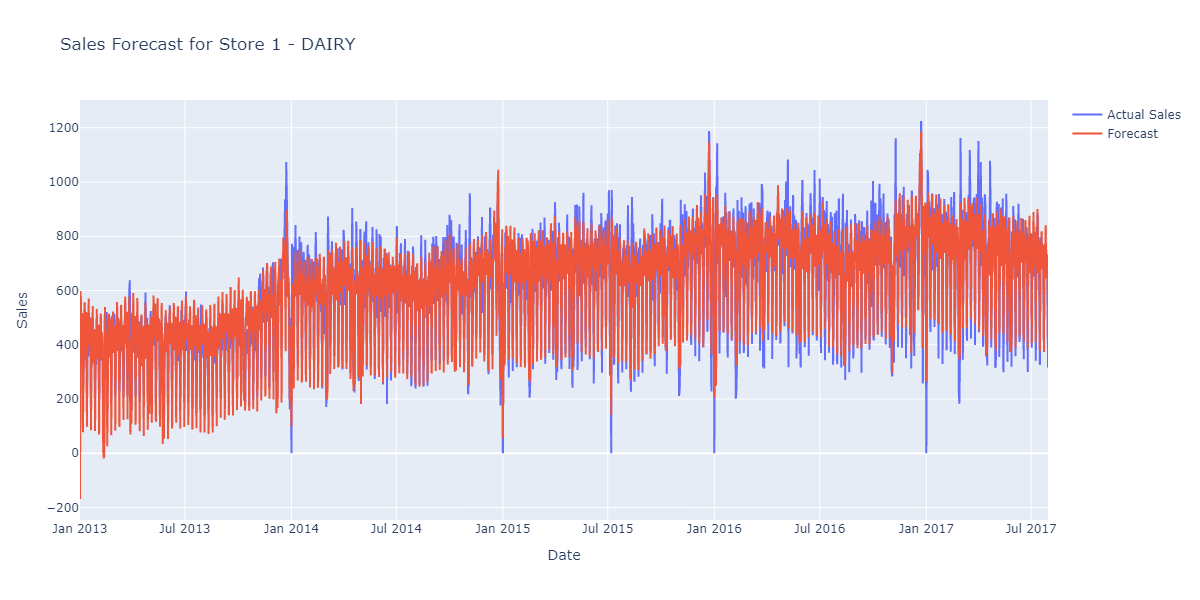

In [17]:
# Forecast sales for Store 1 and the 'DAIRY' product family
result = forecast_sales_with_prophet(
    df=df,
    store_nbr=1,
    family='DAIRY',
    cutoff_date='2017-06-01',
    periods=60,
    include_regressors=True
)

# Print evaluation metrics
print(f"MAE: {result['mae']:.2f}")
print(f"RMSE: {result['rmse']:.2f}")

# Adjust plot size and show
result['plot'].update_layout(width=1200, height=600)
result['plot'].show("png")

### Evaluation:

This chart shows daily sales forecasting for the DAIRY category in Store 1 from Jan 2013 to mid-2017, comparing actual vs. predicted sales.

### Key Points

- **Actual vs Forecast:** Blue line = true sales, red line = model prediction  
- **Performance:** MAE = 45.37, RMSE = 57.30, indicating good baseline accuracy given average sales (~400-800 units/day)  
- **Strengths:** Captures overall trends and seasonality well, especially during high-volume periods  
- **Limitations:** Misses some volatility and occasional unrealistic negative forecasts  

### Performance:

The model effectively forecasts DAIRY sales with solid accuracy, supporting demand planning and inventory optimization over a 4.5-year period.


# 🚀 4. Conclusion & Business Impact

This notebook delivers a production-ready sales forecasting solution using Prophet, capable of generating accurate, daily-level predictions for specific stores and product families.

## 💼 Business Problems Solved

- **📦 Demand Planning:** Anticipates future sales to optimize inventory and reduce stockouts or overstocking.
- **📣 Promotion & Resource Planning:** Accounts for holidays, promotions, and external drivers to support operational and marketing decisions.
- **⚙️ Operational Efficiency:** Automates forecasting workflows, saving time and reducing reliance on manual forecasts.
- **📊 Strategic Decision-Making:** Supports data-driven choices in pricing, procurement, and supply chain management.

## 💪 Key Benefits

- **📈 High Forecast Accuracy:** Achieves solid performance using MAE and RMSE, making it dependable for business use.
- **🔗 Context-Aware Predictions:** Incorporates real-world drivers like promotions, transactions, oil prices, and holidays.
- **🔄 Scalable & Adaptable:** Works for different stores, product families, and forecast horizons with minimal changes.
- **🧩 Automation-Ready:** Designed for smooth integration into ongoing business processes and dashboards.

This project moves beyond exploration—delivering a maintainable, context-aware forecasting pipeline ready to support everyday operations and long-term retail strategy.